In [1]:
import sys
sys.path.append('..')
from src.kitti import *
import numpy as np
import cv2
%matplotlib inline

Read frame transformations from KITTI sequence 00 into a list of frames (frame).

In [2]:
IMAGE_SIZE = 400

def load(file):
    keyframeids, frameids, poses = load_keyframes(file)
    return keyframeids, frameids, poses.reshape(poses.shape[0], 4, 4)

def load_csv(file):
    poses = np.genfromtxt(file, delimiter= " ")
    poses = np.hstack([poses, np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) ])
    return poses.reshape(poses.shape[0], 4, 4)

def transform(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[:i] = np.dot(points[:i], poses[i].T)
    return points
        
def transform2(poses):
    points = poses[:,:,3]
    return points
   
def transform3(poses):
    points = np.repeat(np.array([[0,0,0,1.0]]), len(poses), axis=0) 
    for i in range(1, len(poses)):
        points[i] = np.dot(points[i], poses[i].T)
    return points
    
def plot_trajectory(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1])

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = + pmin[1] / maxxy

    return np.dot(points, t.T)
    

def plot_trajectory2(points):
    # remove y coordinate (we only use x and z to plot a view from above)
    points = points[:, [0,2,3]]
    # compute min and max
    pmin = points.min(axis=0)
    pmax = points.max(axis=0)
    maxxy = max(pmax[0] - pmin[0], pmax[1] - pmin[1]) * 1.01

    t = np.eye(3, dtype=np.float64)
    t[0,0] = IMAGE_SIZE / maxxy
    t[1,1] = -IMAGE_SIZE / maxxy
    t[0,2] = -pmin[0] * IMAGE_SIZE / maxxy
    t[1,2] = IMAGE_SIZE / maxxy + pmin[1] / maxxy + 100
    return np.dot(points, t.T)
    
def plot_trajectory3(points):
    coords = []
    minx = min([p[0] for p in points])
    maxx = max([p[0] for p in points])
    miny = min([p[2] for p in points])
    maxy = max([p[2] for p in points])
    maxxy = max(maxx - minx, maxy - miny)* 1.01

    for p in points:
        #print(p)
        x = IMAGE_SIZE * (p[0] - minx) / (maxxy)
        z = IMAGE_SIZE - IMAGE_SIZE * (p[2] - miny) / (maxxy)
        coords.append([x, z])
    return coords

def new_image():
    img = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), np.uint8)
    img[:] = 255 #or img.fill(255)
    return img

def draw(coords, img, color = (0,0,0)):
    # Draw a black line with thickness of 2 px
    for i in range(1,len(coords)):
        cv2.line(img, (int(coords[i - 1][0]), int(coords[i - 1][1])), (int(coords[i][0]), int(coords[i][1])), color, 2)
    return img

Compute the frame positions by mutiplying every point by a sequence of their transformations
vectorized to improve speed

In [3]:
sequence = 7

folder = '/data/urbinn/datasets/urb_trajectory_output'
#folder = '/home/jeroen/notebooks/urb/resultsba'
keyframeids, frameids, poses = load(folder + '/keyframes_%02d_all_17_1.6_1.6.npy'%(sequence))

posesold = poses
points = transform(poses[:])
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
pointsgt = transform2(gt)[:]
coordsgt = plot_trajectory3(pointsgt)
show2(draw(coordsgt, new_image()), p)

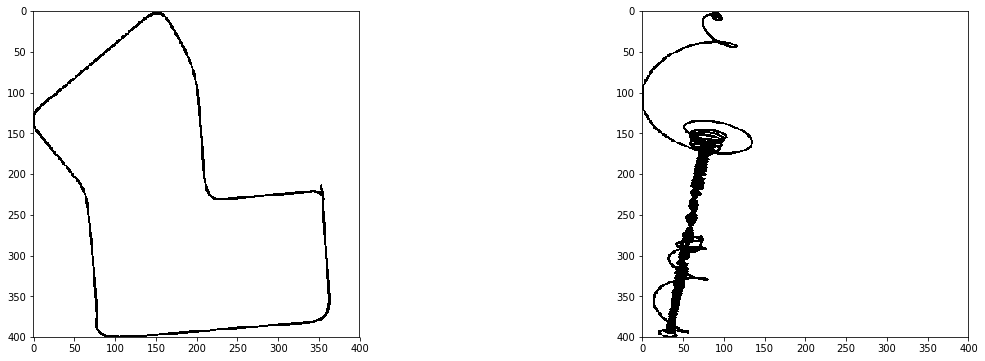

In [7]:
folder = '/data/urbinn/datasets/urb_trajectory_rotationfixed'
folder = '/home/14102307/notebooks/urb/experiments'
keyframeids, frameids, poses = load(folder + '/cv_keyframes.npy')

posesnew = poses
points = transform(poses[:])
coords = plot_trajectory3(points)
p = draw(coords, new_image())

gt = load_csv('/data/urbinn/datasets/kitti/poses/%02d.txt'%(sequence))
pointsgt = transform2(gt)[:]
coordsgt = plot_trajectory3(pointsgt)
show2(draw(coordsgt, new_image()), p)

In [5]:
for i, xy in enumerate(coords):
    print(i, xy[0], xy[1])

0 245.074501175 248.038028408
1 245.469273435 247.54281214
2 246.257186478 246.494601394
3 247.415913646 244.884757544
4 248.92255963 242.630865203
5 250.716880489 239.619445206
6 252.775495376 235.738035432
7 254.983781144 230.836493142
8 257.09771203 224.76097325
9 258.810560647 217.400796732
10 259.721363689 208.673588096
11 259.259196448 198.617850538
12 256.763311358 187.486489075
13 251.546873052 175.759836381
14 243.070944738 164.425899392
15 230.889052949 154.709550959
16 215.079184406 148.278188708
17 196.516846196 147.059199418
18 177.28012054 152.796857296
19 160.52149101 166.36926459
20 150.225620213 186.998842689
21 150.289925485 211.553241149
22 163.058573759 234.354606574
23 187.369009484 247.783283276
24 216.666353708 244.758740104
25 239.309758196 223.271280424
26 242.648985191 190.452929128
27 221.246321726 163.03840159
28 184.782501476 159.928067089
29 157.788542021 187.393682877
30 164.274474787 227.3510526
31 203.164701417 244.382391837
32 238.766356563 217.7044901

In [6]:
p = posesold.copy()
for i in range(1, len(p)):
    p[i] = np.dot( p[i-1], p[i] )
pterug = p.copy()
for i in range(len(p)-1, 0, -1):
    pterug[i] = np.dot( np.linalg.pinv(pterug[i-1]), pterug[i] )

print(posesold[:,2,3])
pterug[:,2,3]

NameError: name 'posesold' is not defined

Show the affine world coodinates for the first 3 poses

In [ ]:
points[:3]

show the converted x,y coordinates to plot the trajectory

In [ ]:
coords[:3]

In [ ]:
show(draw_frame(frame[3281]))